![](header.jpg)

# Homography

Kevin J. Walchko, Phd

17 Aug 2017

---

## References

- OpenCV docs: [Homography](https://www.learnopencv.com/homography-examples-using-opencv-python-c/)

## Math

A Homography is about warp and bending an image (like yoga?) rather than leaving it flat. Basically, the pixel are multiplied by a transformation (a 3×3 matrix) that maps (rotates) the points in one image plane to the corresponding points in the other image plane and translates (3x1 vector) the pixel origin. 

![](image_stitching_1.jpg)

Since we are dealing with 2d images, we do:

$$
\begin{bmatrix}
  x_1 \\
  y_1 \\
  1
\end{bmatrix} =
H_{3x3}
\begin{bmatrix}
  x_2 \\
  y_2 \\
  1
\end{bmatrix} \\
H_{3x3} = \begin{bmatrix}
  Rotation_{2x2} & Translation_{(x,y)} \\
  skew & 1 
\end{bmatrix}
$$

Notice the 1 at the bottom, hopefully this reminds of homogenious transforms, but in 2d instead of 3d.

## Applications

#### Image Stitching

By matching features between 2 images, we can understand the relationship between the images and warp them in such a way, we can join the images together and make a larger panoramic view.

![](image_stitching_2.jpg)

#### Virtual Reality

Just like our little goblin above, we understand the points on the QR code and where the are in real space. If we match those point in the image, we can estimate the orientation of the camera relative to the QR code. Once we have that `pose` (remember that term from earlier?), we can draw a 3D object onto our 2D image and give it the correct orientation and lighting.

![](virtual-reality.jpg)

#### Camera Calibration

Just like above with the VR examples, we can match a target pattern in an image to real world coordinates and estimate the distortion that must occur. Later we will talk about camera calibration and how to do this.

![](calibration.jpg)

#### Perspective Correction

We don't always get the orientation we want in an image. That's okay, because in various applications we can warp (or reorient) the image perspective so we can get what we want. You see stuff like this in the movies all the time and some of it is real.

![](perspective-correction.jpg)

## Homography and OpenCV

To calculate a homography between two images, you need to know at least 4 point correspondences between the two images. If you have more than 4 corresponding points, it is even better. OpenCV will robustly estimate a homography that best fits all corresponding points. Usually, these point correspondences are found automatically by matching features like with SIFT or SURF between the images.

```python
'''
pts_src and pts_dst are numpy arrays of points
in source and destination images. We need at least 
4 corresponding points. 
'''
h, status = cv2.findHomography(pts_src, pts_dst)
 
''' 
The calculated homography can be used to warp 
the source image to destination. Size is the 
size (width,height) of im_dst
'''
 
im_dst = cv2.warpPerspective(im_src, h, size)
```

## Virtual Billboards

In many televised sports events, advertisements are virtually inserted into live video feeds. For example, both soccer and baseball place ads on small advertisement boards right outside the boundary of the field that can be virtually changed. Instead of displaying the same ad to everybody, advertisers can choose which ads to show based on the person’s demographics, location etc. In these applications the four corners of the advertisement board are detected in the video which serve as the destination points. The four corners of the ad serve as the source points. A homography is calculated based on these four corresponding points and it is used to warp the ad into the video frame.

In [5]:
%matplotlib inline 

import cv2         # opencv itself
import numpy as np # matrix manipulations

from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

advert size: (403, 574, 3)
Homography matrix: [[ 4.27796377e-01 -2.48138958e-01  1.00000000e+02]
 [ 4.27796377e-01  2.35757002e-02  1.00000000e+02]
 [ 1.26790175e-03 -1.12281629e-03  1.00000000e+00]]


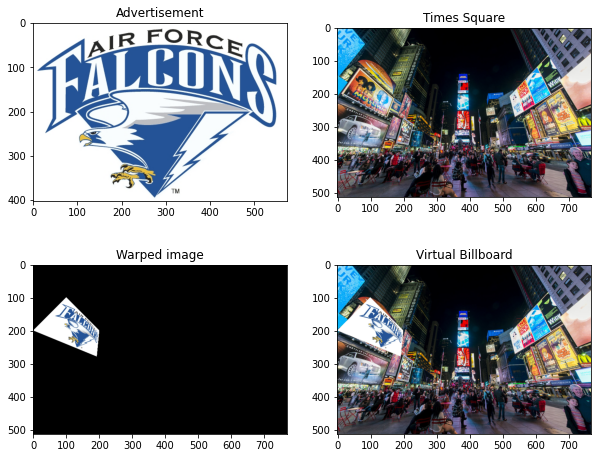

In [6]:
advert = cv2.imread('afa.jpg')
advert = cv2.cvtColor(advert,cv2.COLOR_BGR2RGB)

print('advert size:', advert.shape)

ts = cv2.imread('times-square.jpg')
ts = cv2.cvtColor(ts,cv2.COLOR_BGR2RGB)

# original image dimensions
pts_src = np.array([
    [0, 0],
    [0, advert.shape[0]],
    [advert.shape[0], advert.shape[1]],
    [advert.shape[1], 0]
])

# destination to map too
# note: I just eye balled this ... not perfect!
pts_dst = np.array([
    [100, 100],
    [0, 200],
    [150, 330],
    [200, 200]
])

h, status = cv2.findHomography(pts_src, pts_dst)

print('Homography matrix:', h)

# warp advert image
im_dst = cv2.warpPerspective(advert, h, (ts.shape[1], ts.shape[0]))

# this section of code will create a mask, then replace the masked 
# area with our advert:
# 1. convert copy to grayscale
# 2. threshold image so it is just black and white (binary)
# 3. invert mask (black)
# 4. cut out existing current colors there, anything and'ed with 0 is 0
# 5. now add the two images together and fill in the cut out
img2gray = cv2.cvtColor(im_dst,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
img1_bg = cv2.bitwise_and(ts,ts,mask = mask_inv)
final = img1_bg + im_dst

plt.subplot(2,2,1)
plt.imshow(advert)
plt.title('Advertisement')

plt.subplot(2,2,2)
plt.imshow(ts)
plt.title('Times Square')

plt.subplot(2,2,3)
plt.imshow(im_dst)
plt.title('Warped image')

plt.subplot(2,2,4)
plt.imshow(final)
plt.title('Virtual Billboard');